In [1]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/pepdoc' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import pepdoc_params as params

In [2]:
sub_list = params.sub_list
data_dir = params.data_dir
fig_dir = f'{curr_dir}/figures' #where to save the figures
results_dir = f'{curr_dir}/results' #where to save the results

#stim info
categories = params.categories
labels = params.labels

#channels of interest
channels = params.channels

#analysis window info
pre_stim = params.pre_stim
post_stim = params.post_stim
bin_size = params.bin_size
bin_length = params.bin_length

start_window = params.start_window
stim_onset = params.stim_onset
stim_offset = params.stim_offset
timepoints = params.timepoints

#### Measure SNR

In [3]:
rois = ['dorsal','ventral','frontal','occipital']

snr_trial_summary = pd.DataFrame(columns = ['sub']+ rois)
snr_first_summary = pd.DataFrame(columns = ['sub']+ rois)

#loop through subs
for sub in sub_list:
    snr_vals = []
    snr_vals.append(sub)
    snr_first_vals = []
    snr_first_vals.append(sub)
    for roi in rois:
        #load sub data
        #data are formatted stim x time x channels
        sub_data = np.load(f'{data_dir}/{sub}/{roi}_data.npy')

        #calculate mean during stim period
        mean_stim = np.mean(sub_data[:,stim_onset:stim_offset,:], axis = 1)

        #Calculate mean during first 100 ms of sitm period
        first_window = np.mean(sub_data[:,stim_onset:stim_onset+20,:], axis = 1)

        
        #calculate SD during baseline period
        sd_baseline = np.std(sub_data[:,:stim_onset,:], axis = 1)

        #calculate SNR for whole trial
        snr_trial = mean_stim/sd_baseline

        #calculate SNR for first 100 ms of trial
        snr_first = first_window/sd_baseline

        #calculate global mean
        global_trial_mean = np.abs(np.mean(snr_trial))
        global_first_mean = np.abs(np.mean(snr_first))

        snr_vals.append(global_trial_mean)
        snr_first_vals.append(global_first_mean)


    #concat snr values to snr_summary
    snr_trial_summary = pd.concat([snr_trial_summary,pd.DataFrame([snr_vals], columns = snr_trial_summary.columns, index = None)])
    snr_first_summary = pd.concat([snr_first_summary,pd.DataFrame([snr_first_vals], columns = snr_first_summary.columns, index = None)])

#save snr summary
snr_trial_summary.to_csv(f'{results_dir}/snr_trial_summary.csv', index = False)
snr_first_summary.to_csv(f'{results_dir}/snr_first_summary.csv', index = False)
    

    

In [4]:
snr_trial_summary[rois].mean()

dorsal       4.853303
ventral      5.594454
frontal      6.192142
occipital    6.258458
dtype: float64

#### Examine whether dorsal ventral channels split

In [17]:
'''
Extract COIs
'''
rois = ['occipital', 'ventral','dorsal','frontal']
channel_mat = np.load(f'{results_dir}/channel_similarity.npy')
cois = []
for roi in rois:
    cois = cois + channels[roi]

channel_mat = np.load(f'{results_dir}/channel_similarity.npy')

channel_df = pd.DataFrame(channel_mat, columns = np.arange(1,257), index = np.arange(1,257))

channel_df = channel_df.loc[cois,cois]



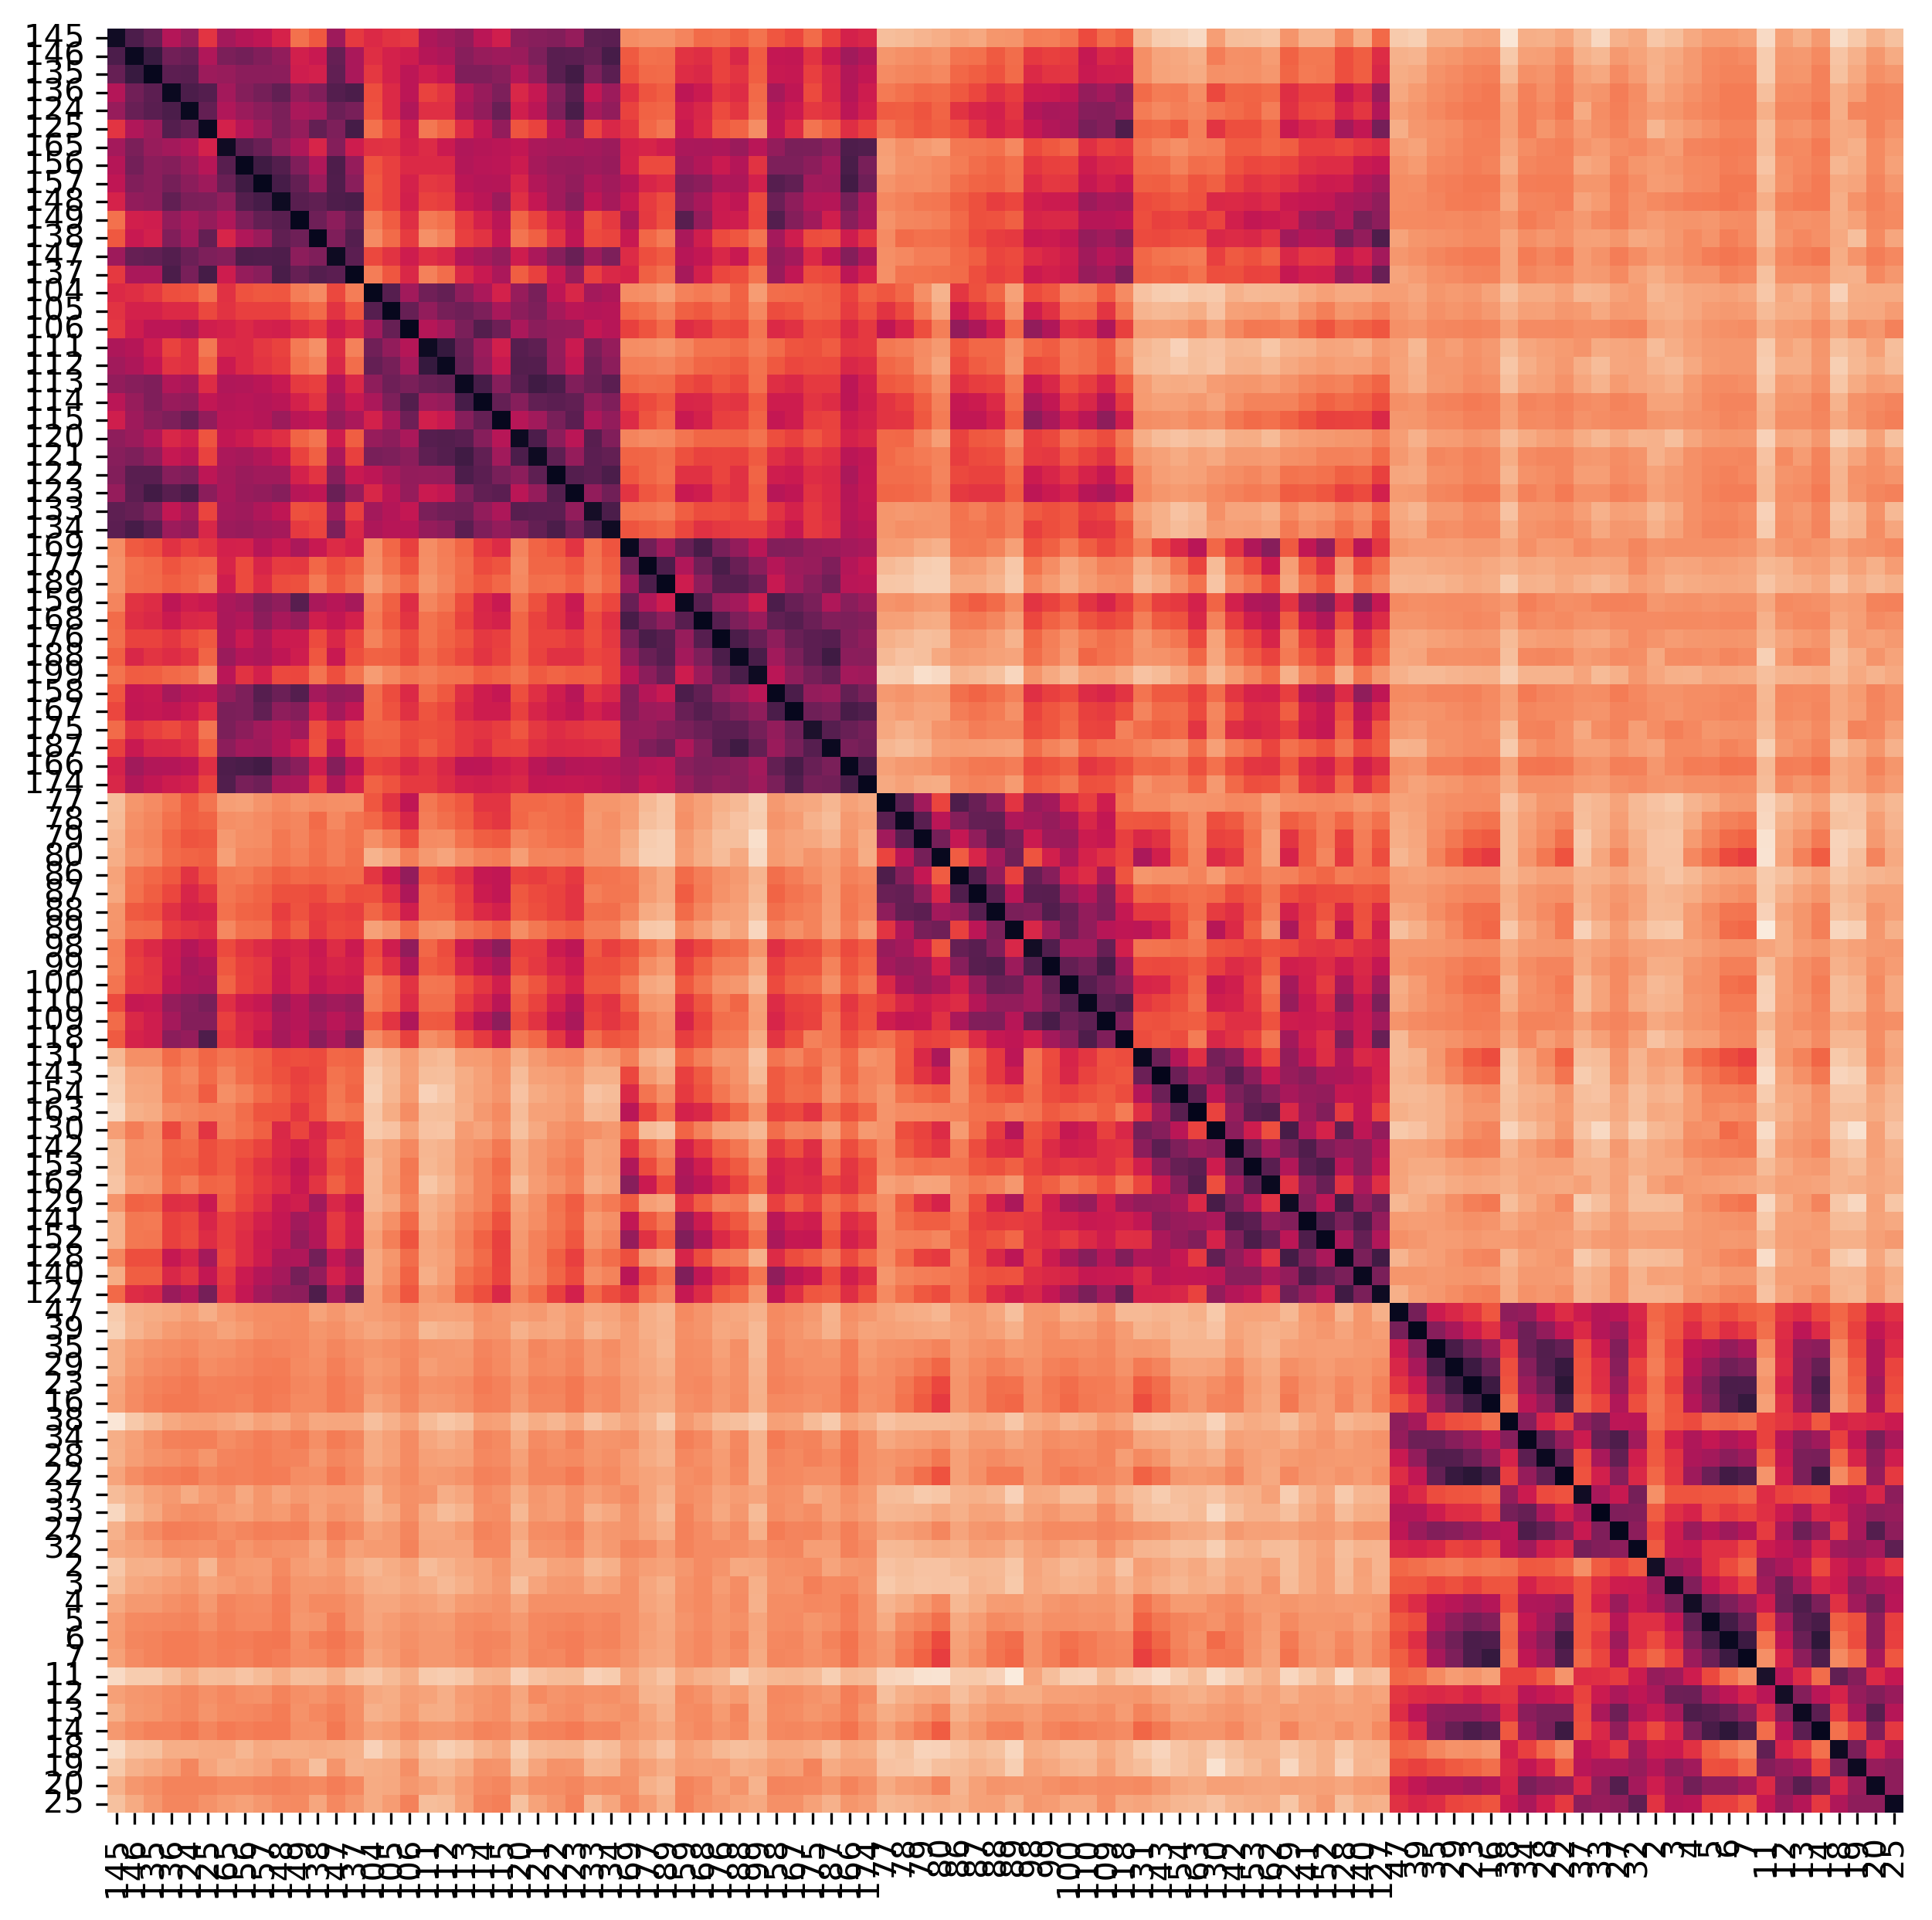

In [18]:
'''
Plot channels numerically
'''
plt.figure(figsize=(10, 10), dpi=300)
fig = sns.heatmap(channel_df,xticklabels = True, yticklabels = True,cbar=False)

#fig.ax_cbar.set_visible(False)




plt.savefig(f'{fig_dir}/dv_channel_similarity.png', dpi = 300, bbox_inches = 'tight')


#### Count channels

In [50]:
"""Count how many channels are missing on average"""

channel_perc = []
for sub in sub_list:
    for category in categories: #loop through categories
        

        curr_df = pd.read_csv(f'/{data_dir}/{sub}/{category}s/{category}{1}.tsv' , sep='\t')#read in the file; first value is the file name
  

        channel_perc.append(1-((curr_df.shape[0]-1)/256))

print('missing channels:',np.mean(channel_perc))

missing channels: 0.1556640625


#### ERP Plots

In [5]:
'''
Calc CIs
'''

rois = ['dorsal','ventral','occipital','frontal']
roi_onsets = []
for roi in rois:
    ci_data = np.load(f'{results_dir}/erp/{roi}_erp_cis.npy')
    ci_data = ci_data[:,stim_onset:]

    onset = np.min(np.where(ci_data[2,:] == 1))
    onset = (onset *bin_length)
    roi_onsets.append(onset)
    print(f'{roi} onset:', onset)

dorsal onset: 24
ventral onset: 40
occipital onset: 36
frontal onset: 40


(0, 'dorsal') max time: 230
(1, 'ventral') max time: 254


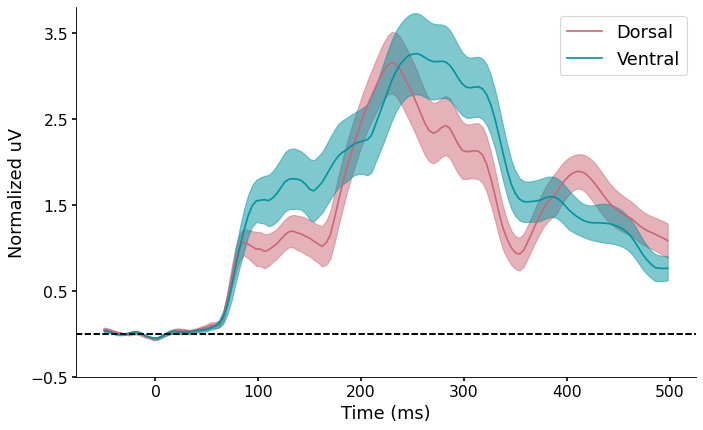

In [9]:
'''
Plot ERPs for each ROI with shading
'''
rois = ['ventral', 'dorsal']
roi_names = ['Ventral', 'Dorsal']
colors = ['#CC6677','#00949e']

rois = ['dorsal', 'ventral']
roi_names = ['Dorsal','Ventral']
#colors = ['#00949e','#CC6677']
onsets = roi_onsets

plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_erp = np.load(f'{results_dir}/erp/{roi[1]}_mean_ts.npy')

        
    #pre_stim = roi_erp[:,:stim_onset] #pull out the pre-stimulus data
    #pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    #roi_norm = roi_erp - pre_stim[:,None]#subtract the prestimulus average from each timepoint
    
    roi_mean = np.mean(roi_erp, axis=0)
    maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
    print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
    
    
    sem = np.std(roi_erp, ddof=1, axis =0) / np.sqrt(roi_erp.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0, color='k', linestyle='--')
    
    #plt.axvline(x=onsets[roi[0]], color=colors[roi[0]], linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Normalized uV',fontsize=16)
    
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(-.5,3.8)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 1))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/erp_plot.png', dpi=300)


#### Test ERP onset

In [13]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'],['occipital','dorsal'] ]
boot_df = pd.read_csv(f'{results_dir}/erp/erp_onset_boot.csv')

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print('p val', stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    print('count of diffs', time_count)
    print(f'{roi[0]} mean', np.mean(boot_df[roi[0]]))
    print(f'{roi[1]} mean', np.mean(boot_df[roi[1]]))
    print('mean diff', np.mean(diff))

p val 2.785018974335661e-49
count of diffs 5737
dorsal mean 28.1172
ventral mean 37.43
mean diff -9.3128
p val 1.987616357790127e-207
count of diffs 3475
occipital mean 35.1944
dorsal mean 28.1172
mean diff 7.0772


/home/vayzenbe/anaconda3/envs/ml_new/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


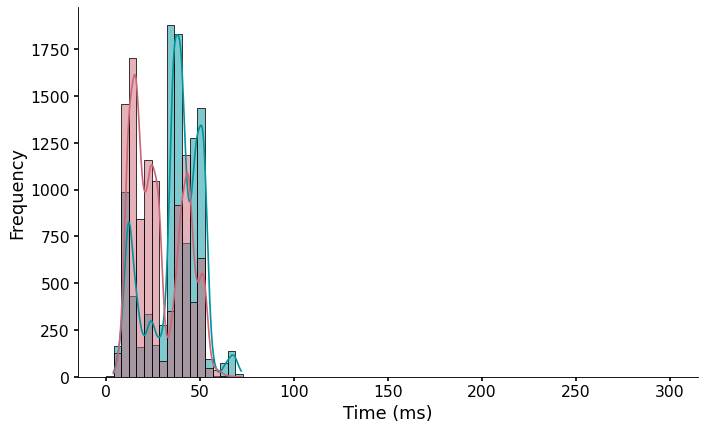

In [10]:



boot_df = pd.read_csv(f'{results_dir}/erp/erp_onset_boot.csv')
boot_df.drop(columns = ['frontal','occipital'], inplace = True)
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e']
plt.figure(figsize=(10, 6), dpi=80)
sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


#sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/erp_onset_histogram.png', dpi=300)


#### Main decoding plots

In [25]:
'''
Calc CIs
'''

rois = ['dorsal','ventral','occipital','frontal']
roi_onsets = []
for roi in rois:
    ci_data = np.load(f'{results_dir}/decode/{roi}_decode_cis.npy')
    ci_data = ci_data[:,stim_onset:]

    onset = np.min(np.where(ci_data[2,:] == 1))
    onset = (onset *bin_length)+2
    roi_onsets.append(onset)
    print(f'{roi} onset:', onset)

dorsal onset: 64
ventral onset: 92
occipital onset: 64
frontal onset: 108


(0, 'dorsal') max time: 210 0.35174999999999995
(1, 'ventral') max time: 246 0.3499375


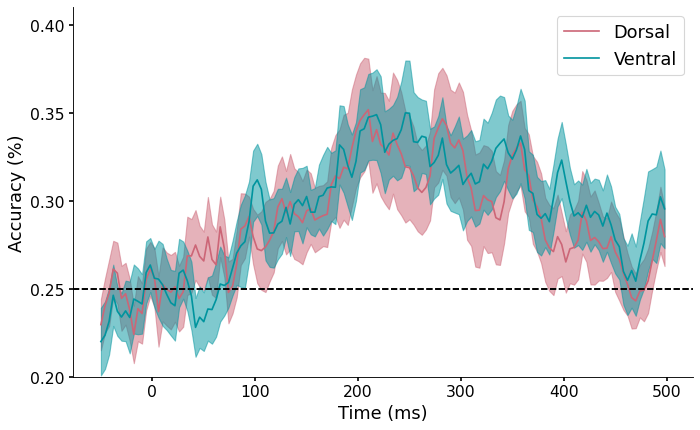

In [19]:
'''
Plot decoding accuracy for each ROI with shading
'''


colors = ['#CC6677','#00949e','green','yellow']

rois = ['dorsal', 'ventral']
#colors = ['#00949e','#CC6677']
onsets = roi_onsets



plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_decoding.npy')
    roi_cis = np.load(f'{results_dir}/decode/{roi[1]}_decode_cis.npy')
    roi_mean = np.mean(roi_decoding, axis=0)
    maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
    print(f'{roi} max time:', ((maxtime *bin_length)-start_window),np.max(roi_mean))
    
    sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0.25, color='k', linestyle='--')
    
    #plt.axhline(y=0.2215, color='k', linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Accuracy (%)',fontsize=16)
    #plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
    #plt.yticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(.2,.41)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, .05))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/decoding_plot.png', dpi=300)


In [26]:
roi = 'ventral'
ci_data = np.load(f'{results_dir}/decode/{roi}_decode_cis.npy')

roi_mean = np.mean(np.load(f'{results_dir}/decode/{roi}_decoding.npy'),axis =0)

In [27]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'],['dorsal','occipital'],['ventral','occipital'] ]
boot_df = pd.read_csv(f'{results_dir}/onsets/decode_onset_boot.csv')

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print(roi)
    print('p val', stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    print('count of diffs', time_count)
    print('mean diff', np.mean(diff))
    print('mean & SD', roi[0], np.mean(boot_df[roi[0]]), np.std(boot_df[roi[0]]) )
    print('mean & SD', roi[1], np.mean(boot_df[roi[1]]), np.std(boot_df[roi[1]]))



['dorsal', 'ventral']
p val 5e-324
count of diffs 7010
mean diff -16.4836
mean & SD dorsal 63.0996 31.6531780369682
mean & SD ventral 79.5832 32.0934491409073
['dorsal', 'occipital']
p val 1.230776437404771e-58
count of diffs 5806
mean diff -9.0072
mean & SD dorsal 63.0996 31.6531780369682
mean & SD occipital 72.1068 21.994249106528247
['ventral', 'occipital']
p val 2.3318765195659755e-279
count of diffs 3233
mean diff 7.4764
mean & SD ventral 79.5832 32.0934491409073
mean & SD occipital 72.1068 21.994249106528247


/home/vayzenbe/anaconda3/envs/ml_new/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:67: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


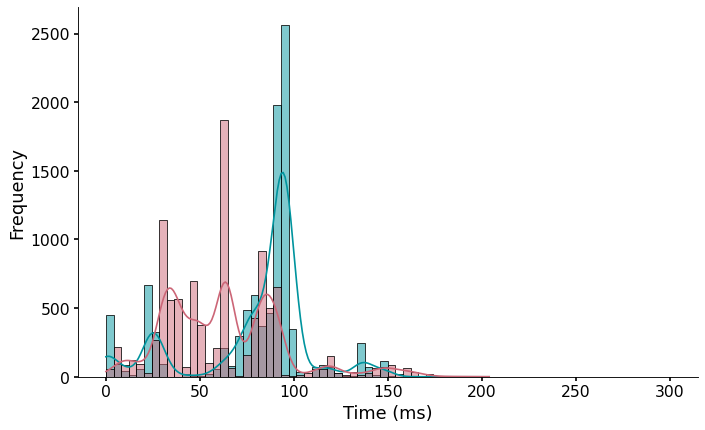

In [28]:
"""Decoding onset histogram"""


boot_df = pd.read_csv(f'{results_dir}/onsets/decode_onset_boot.csv')
boot_df = boot_df.drop(columns = ['frontal'])
boot_df = boot_df.drop(columns = ['occipital'])
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e']
plt.figure(figsize=(10, 6), dpi=80)
sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


#sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/decoding_onset_histogram.png', dpi=300)



#### Control analyses

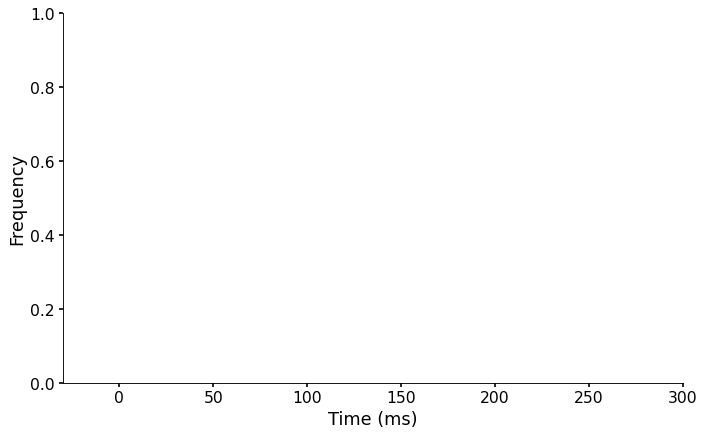

In [67]:
"""
Decoding onset histogram
With channel resample
"""

rois = ['dorsal','ventral','occipital']

boot_df = pd.DataFrame(columns = rois)
for roi in rois:
    #load each rois's boot data
    roi_df = pd.read_csv(f'{results_dir}/onsets/{roi}_channel_resample_boots.csv')

    #add data to a dataframe
    boot_df[roi] = roi_df[roi]


boot_df = boot_df.drop(columns = ['occipital'])
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e']
plt.figure(figsize=(10, 6), dpi=80)
ax = sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


#sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/decoding_onset_histogram_resampled_channels.png', dpi=300)

In [29]:
"""Decoding without tools"""
#category_comp = [['nontool','bird','insect']] #initial categories without tools
category_comp = [['nontool','bird','insect'],['tool','bird','insect'], ['tool','nontool','insect'], ['tool','nontool','bird']] #initial categories without tools
rois = ['dorsal','ventral']        
for comps in category_comp:
    suf = "_".join(comps)
    print(suf)
        

    for roi in enumerate(rois):
        roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_decoding_{suf}.npy')

        sig_ts = []
        for time in range(0, roi_decoding.shape[1]):
            p_val = stats.ttest_1samp((roi_decoding[:,time]), 1/len(comps), axis = 0, alternative='greater')
            sig_ts.append(p_val[1])

        sig_ts = np.array(sig_ts)
        onset = np.min(np.where(sig_ts[stim_onset:] <= .05))+stim_onset
        onset = ((onset *bin_length)-start_window)

        print(roi[1], onset)

nontool_bird_insect
dorsal 50
ventral 98
tool_bird_insect
dorsal 66
ventral 82
tool_nontool_insect
dorsal 126
ventral 98
tool_nontool_bird
dorsal 70
ventral 98


In [35]:
roi_decoding = np.mean(np.load(f'{results_dir}/decode/ventral_decoding_nontool_bird_insect.npy'),axis =0)

In [30]:
category_comp = []
iter = 1000

#append each pairwise category comparison
#for cat1 in range(0,len(categories)):
#    for cat2 in range(cat1+1,len(categories)):
#        category_comp.append([categories[cat1],categories[cat2]])

rois = ['dorsal','ventral']

#create a dataframe to store the onset times
onset_df = pd.DataFrame(columns = rois)

for roi in rois:
    
    for comps in category_comp:
        suf = "_".join(comps)
        print(suf)
        
        if category_comp.index(comps) == 0:
            roi_decoding = np.load(f'{results_dir}/decode/{roi}_decoding_{suf}.npy')
        else:
            roi_decoding = np.vstack((roi_decoding,np.load(f'{results_dir}/decode/{roi}_decoding_{suf}.npy')))

    #sample with replacement

    #convert to dataframe
    roi_df = pd.DataFrame(roi_decoding, columns = np.arange(0,roi_decoding.shape[1]))
    
    onset_boot = []
    for ii in range(0,iter):
        #sample with replacement
        roi_resample = roi_df.sample(n = len(sub_list), replace = True, axis = 0)

        #find first significant timepoint
        sig_ts = []
        for time in range(0, roi_resample.shape[1]):
            p_val = stats.ttest_1samp((roi_resample.iloc[:,time]), 1/len(comps), axis = 0, alternative='greater')
            sig_ts.append(p_val[1])

        sig_ts = np.array(sig_ts)
        onset = np.min(np.where(sig_ts[stim_onset:] <= .05))+stim_onset
        onset = ((onset *bin_length)-start_window)
        onset_boot.append(onset)

    onset_df[roi] = onset_boot





In [31]:
onset_df.mean()

dorsal     57.792
ventral    58.932
dtype: float64

nontool_bird_insect
(0, 'dorsal') max time: 358
(1, 'ventral') max time: 182


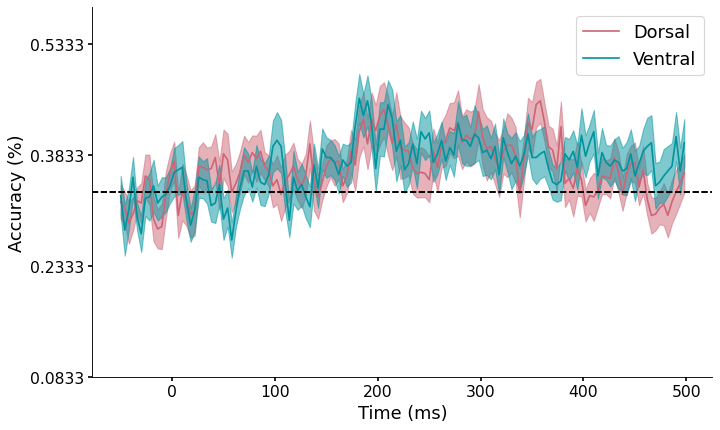

tool_nontool
(0, 'dorsal') max time: 202
(1, 'ventral') max time: 218


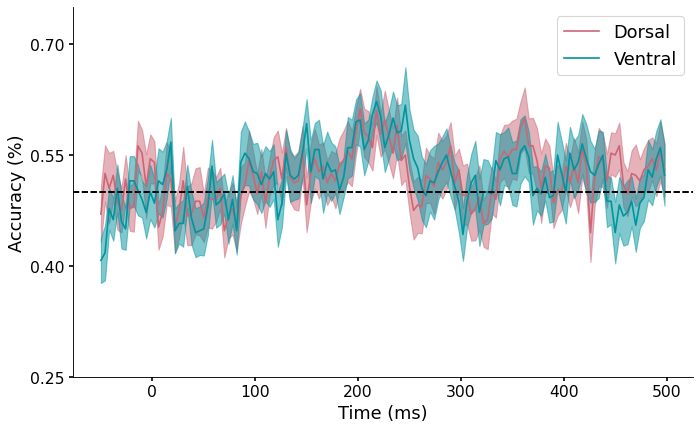

tool_bird
(0, 'dorsal') max time: 290
(1, 'ventral') max time: 222


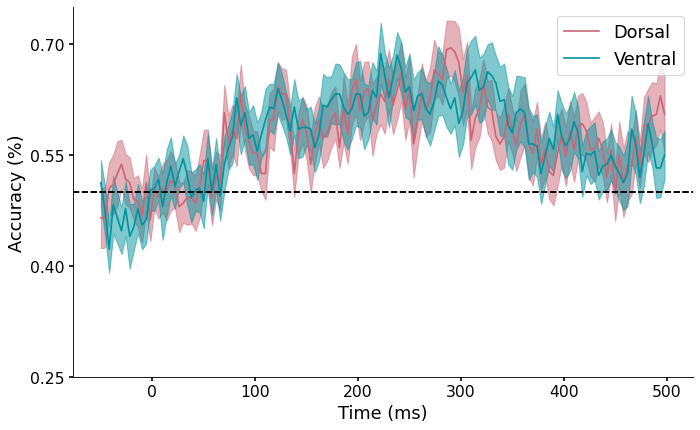

tool_insect
(0, 'dorsal') max time: 246
(1, 'ventral') max time: 246


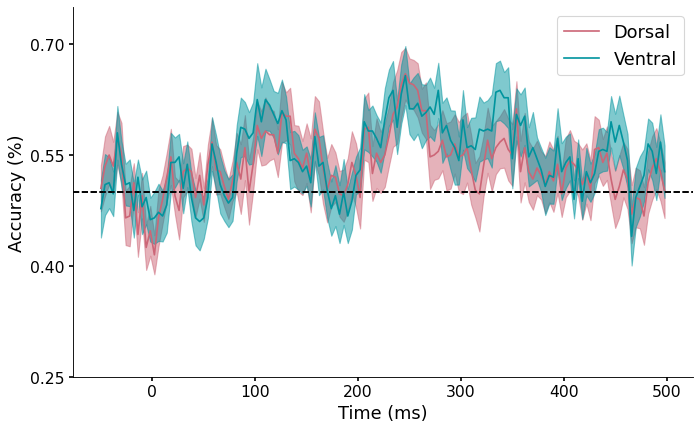

nontool_bird
(0, 'dorsal') max time: 298
(1, 'ventral') max time: 150


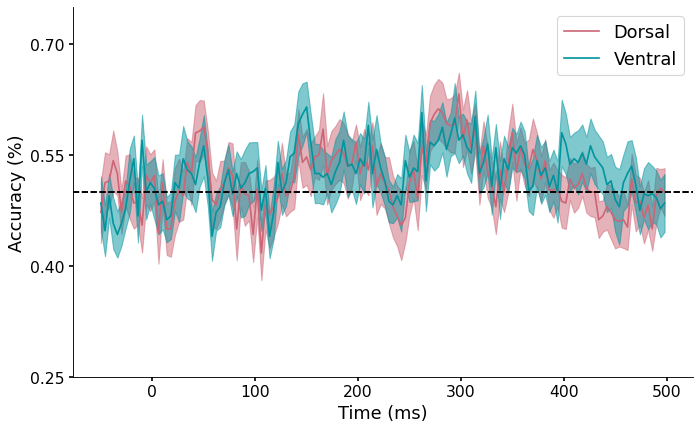

nontool_insect
(0, 'dorsal') max time: 362
(1, 'ventral') max time: 182


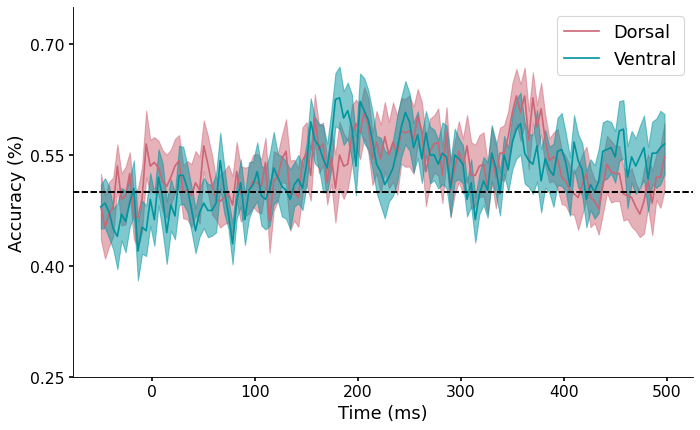

bird_insect
(0, 'dorsal') max time: 210
(1, 'ventral') max time: 186


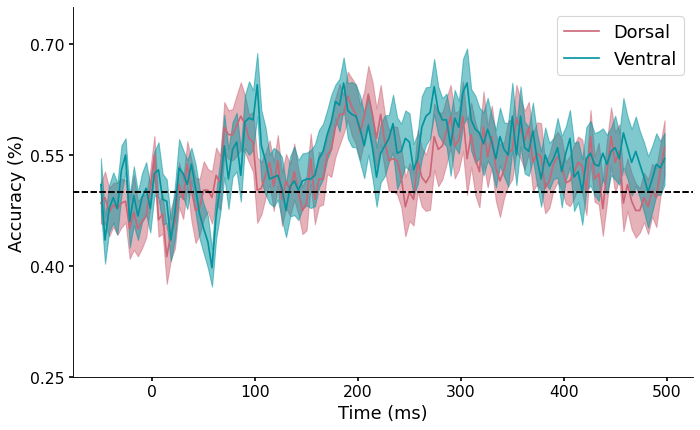

In [68]:
"""
Decoding sig for pairwise comparisons

"""
category_comp = [['nontool','bird','insect']] #initial categories without tools


#append each pairwise category comparison
for cat1 in range(0,len(categories)):
    for cat2 in range(cat1+1,len(categories)):
        category_comp.append([categories[cat1],categories[cat2]])


colors = ['#CC6677','#00949e','green']

rois = ['dorsal', 'ventral']
#colors = ['#00949e','#CC6677']
onsets = [66,82]

alpha_level = .95

for comps in category_comp:
    suf = "_".join(comps)
    print(suf)
        


    plt.figure(figsize=(10, 6), dpi=80)
    for roi in enumerate(rois):
        roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_decoding_{suf}.npy')
        #roi_cis = np.load(f'{results_dir}/decode/{roi[1]}_decode_cis.npy')
        roi_mean = np.mean(roi_decoding, axis=0)
        maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
        print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
        
        sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

        plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
        plt.axhline(y=1/len(comps), color='k', linestyle='--')
        
        #plt.axhline(y=0.2215, color='k', linestyle='--')
        plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
        plt.legend(fontsize=16)

        plt.xlabel('Time (ms)',fontsize=16)
        plt.ylabel('Accuracy (%)',fontsize=16)
        #plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
        #plt.yticks(np.arange(min(x), max(x)+1, 1.0))
        plt.xticks(fontsize= 14)
        plt.yticks(fontsize= 14)
        plt.ylim(1/len(comps) -.25,1/len(comps) +.25)

        ax = plt.gca()
        ax.xaxis.set_tick_params(width=1.5)
        ax.yaxis.set_tick_params(width=1.5)

        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, .15))

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.show()
        
        #plt.savefig(f'{fig_dir}/decoding_plot.png', dpi=300)
    plt.close()


#### Controling for other regions

In [18]:
'''
Calc CIs
'''

rois = ['dorsal','ventral']
control = 'partial_brain'
roi_onsets = []
for roi in rois:
    ci_data = np.load(f'{results_dir}/decode/{roi}_{control}_decode_cis.npy')
    ci_data = ci_data[:,stim_onset:]

    onset = np.min(np.where(ci_data[2,:] == 1))
    onset = (onset *bin_length)
    roi_onsets.append(onset)
    print(f'{roi} onset:', onset)

dorsal onset: 48
ventral onset: 76


(0, 'dorsal') max time: 158
(1, 'ventral') max time: 126


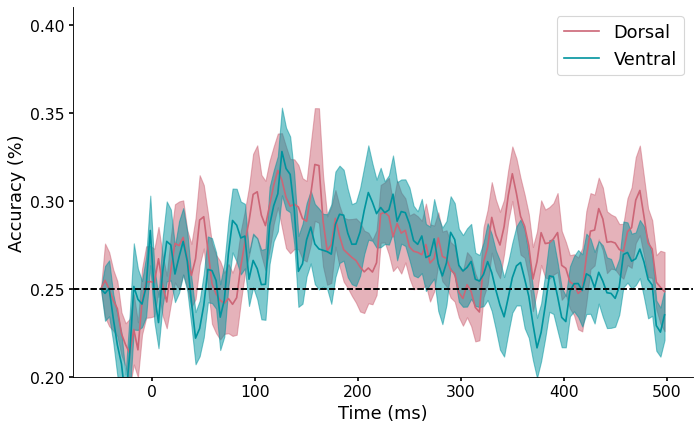

In [20]:
'''
Plot decoding accuracy for each ROI with shading
'''


colors = ['#CC6677','#00949e','green','yellow']

rois = ['dorsal', 'ventral']
control = 'partial_brain'
#colors = ['#00949e','#CC6677']
#onsets = roi_onsets


plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_{control}_decode.npy')
    #roi_cis = np.load(f'{results_dir}/decode/{roi[1]}_decode_cis.npy')
    roi_mean = np.mean(roi_decoding, axis=0)
    maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
    print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
    
    sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0.25, color='k', linestyle='--')
    
    #plt.axhline(y=0.2215, color='k', linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Accuracy (%)',fontsize=16)
    #plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
    #plt.yticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(.2,.41)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, .05))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/control_{control}_decoding_plot.png', dpi=300)


ValueError: x and y must have same first dimension, but have shapes (1,) and (75,)

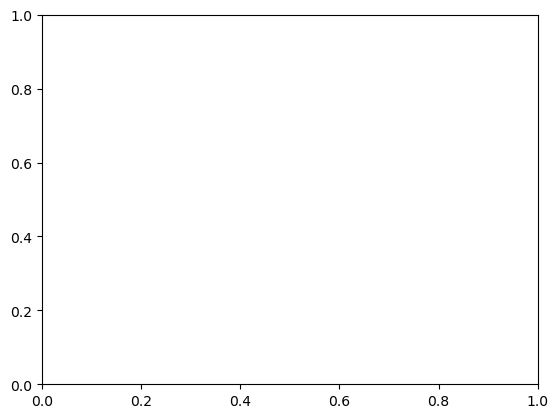

In [6]:
plt.plot(timepoints, roi_mean)

In [7]:
timepoints.shape

AttributeError: 'int' object has no attribute 'shape'